# Minimal example

In this notebook we show how to interface [pyABC](https://github.com/icb-dcm/pyabc) with the [Morpheus](https://morpheus.gitlab.io/) toolbox.

In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
import numpy as np
import pandas as pd
import os
import tempfile
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

ABC.External ERROR: Install rpy2 to enable simple support for the R language.


A Morpheus model is created by passing a Morpheus XML file to the ``fmc.model.MorpheusModel`` class. Here we choose one of Morpheus' build-in example models and need to save that model file `MAPK_SBML.xml` to our current folder (just open the Morpheus-GUI, select `Examples/ODE/MAPK_SBML` and save that model as `MAPK_SBML.xml`).

Then, we need to specify the mapping of parameters to xpaths in the model file, to tell pyABC where to put parameters in the model. The following example code assumes that Morpheus is being installed from source, otherwise if Morpheus was installed via Docker, then adjust the path to the Morpheus simulator executable as needed, e.g. executable=`"/usr/bin/morpheus"`.

In [2]:
file_ = str((Path(os.getcwd())) / 'models' / 'MAPK_SBML.xml')
par_map = {'V1': './CellTypes/CellType/System/Constant[@symbol="V1"]',
           'V2': './CellTypes/CellType/System/Constant[@symbol="V2"]',
           'k3': './CellTypes/CellType/System/Constant[@symbol="k3"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/usr/local/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)
print(model)

MorpheusModel {
	name      : /home/emad/Insync/blackhand.3@gmail.com/Google Drive/Bonn/Gitlab/fit/doc/example/models/MAPK_SBML.xml
}


Let us generate some dummy observed data. Therefore, we sample from freely chosen (termed 'true') parameter values. The returned value contains a link to a folder which has been newly created to accommodate all simulation files. By default, that folder is in the system's temporary folders, but that can also be customized.

The parameters we define here must correspond to Constants in the Morpheus XML file.

In [3]:
true_pars = {'V1': 2.7, 'V2': 0.25, 'k3': 0.025}
limits = {key: (0.5 * val, 2 * val) for key, val in true_pars.items()}

# generate data
observed_data = model.sample(true_pars)

Here, we specified the output to be a dictionary object. The output format can also be customized.

As usual, we have to define a prior for our parameters. Also, we have to define a distance which computes a scalar value from the mismatch between generated data and dummy observed data. Note that also this step can be customized, e.g. for arbitrary summary statistics.

In [4]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

def distance(val1, val2):
    d = np.sum([np.sum(np.abs(val1[key] - val2[key])) \
                for key in ['IdSumstat__MAPK_P', 'IdSumstat__MKK_P']])
    return d

Now, we are able to run our ABC analysis as usual. The ``pyabc.external`` classes take care of all calls to the external simulator. These simulation runs only take a few seconds for this example.

In [5]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=20)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, observed_data)

ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-09-29 15:50:12>


In [6]:
abc.run(max_nr_populations=5)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.45243690e+04.
ABC INFO: Accepted: 20 / 48 = 4.1667e-01, ESS: 2.0000e+01.
ABC INFO: t: 1, eps: 1.19214399e+04.
ABC INFO: Accepted: 20 / 53 = 3.7736e-01, ESS: 1.6659e+01.
ABC INFO: t: 2, eps: 9.52910507e+03.
ABC INFO: Accepted: 20 / 62 = 3.2258e-01, ESS: 1.0422e+01.
ABC INFO: t: 3, eps: 6.43883703e+03.
ABC INFO: Accepted: 20 / 58 = 3.4483e-01, ESS: 1.5828e+01.
ABC INFO: t: 4, eps: 5.57574759e+03.
ABC INFO: Accepted: 20 / 40 = 5.0000e-01, ESS: 1.6468e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:07.063827, end_time=2021-09-29 15:50:19>


We can also plot some results to see what pyABC did.

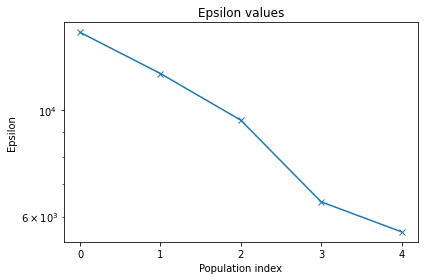

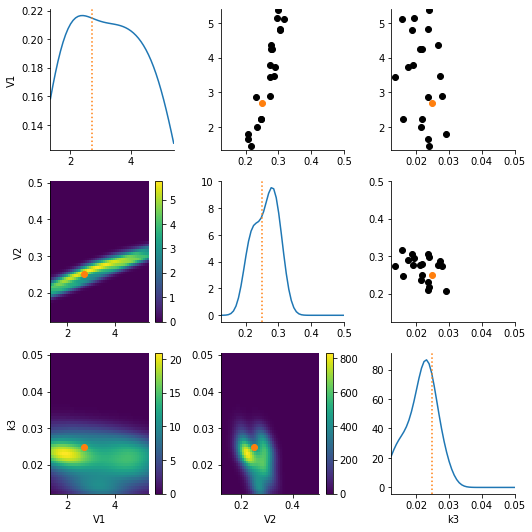

In [7]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()